#Part 1


You are a data scientist in an AI company. You are given a dataset of images containing over 15,000 images of indoor locations. The dataset was originally from MIT built to tackle the problem of indoor scene recognition. All images are in JPEG format and have been divided into 67 categories. The number of images per category varies. However, there are at least 100 images for each category.

There are some issues of  image quality in the following folder

Laboratorywet

Laundromat

Library

Livingroom

Lobby

locker_room

## 1.Download the dataset that is about 2 GB from Kaggle into the local disk and unzip it.

In [3]:
import pandas as pd
from sklearn import preprocessing
import re
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import PIL #Python Imaging Library
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [2]:
img_dir = '/content/drive/MyDrive/archive/'
os.listdir(img_dir)

['TestImages.txt',
 'TrainImages.txt',
 'indoorCVPR_09annotations',
 'indoorCVPR_09',
 'extraClasses']

In [ ]:
# Remove any corrupted file
# Explaination: https://stackoverflow.com/questions/69607117/tensorflow-invalid-argument-input-size-should-match-but-they-differ-by-2/73004159#73004159
import glob
img_dir3 = '/content/drive/MyDrive/archive/indoorCVPR_09/Images'
img_paths = glob.glob(os.path.join(img_dir3, '*', '*.*'))

for image_path in img_paths:
    try:
        img_bytes = tf.io.read_file(image_path)
        decoded_img = tf.io.decode_image(img_bytes)
    except tf.errors.InvalidArgumentError as e:
        print(f"Found bad file: {image_path}.")
        os.remove(image_path)

In [4]:
total_files =0
for root, dirs, files in os.walk(str(img_dir)):
    level = root.replace(str(img_dir), '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/ ({len(files)} files)')
    total_files += len(files)
print(f'There are {total_files -1} images in this dataset')

/ (2 files)
indoorCVPR_09annotations/ (0 files)
    Annotations/ (0 files)
        subway/ (10 files)
        waitingroom/ (14 files)
        toystore/ (17 files)
        studiomusic/ (17 files)
        tv_studio/ (17 files)
        stairscase/ (19 files)
        trainstation/ (19 files)
        warehouse/ (53 files)
        videostore/ (17 files)
        winecellar/ (16 files)
        restaurant_kitchen/ (1 files)
        nursery/ (14 files)
        museum/ (15 files)
        operating_room/ (15 files)
        shoeshop/ (19 files)
        poolinside/ (17 files)
        restaurant/ (16 files)
        prisoncell/ (18 files)
        pantry/ (19 files)
        office/ (108 files)
        laundromat/ (19 files)
        movietheater/ (14 files)
        kitchen/ (310 files)
        mall/ (19 files)
        library/ (17 files)
        livingroom/ (132 files)
        meeting_room/ (91 files)
        laboratorywet/ (15 files)
        locker_room/ (2 files)
        lobby/ (19 files)
        gym/

In [5]:
num_classes = 67 - 50
img_dir2 = '/content/drive/MyDrive/archive/indoorCVPR_09/Images/'

In [6]:
room_dir = [ name for name in list(os.listdir(img_dir2)) if os.path.isdir(os.path.join(img_dir2, name)) ]
room_dir.sort()
print(f' The room labels = {room_dir}')

 The room labels = ['bathroom', 'bedroom', 'children_room', 'cloister', 'clothingstore', 'corridor', 'florist', 'gameroom', 'hairsalon', 'kindergarden', 'laundromat', 'locker_room', 'museum', 'nursery', 'shoeshop', 'trainstation', 'tv_studio']


In [7]:
batch_size = 32
image_height = 256
image_width = 256
train_test_split = 0.2


In [8]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  img_dir2,
  labels='inferred', # labels are generated from the directory structure
  label_mode='int', #'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
  validation_split= train_test_split,
  subset="training",
  seed= 1001, #fix the seed
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 3410 files belonging to 17 classes.
Using 2728 files for training.


In [9]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
  img_dir2,
  labels='inferred',
  label_mode='int',
  validation_split= train_test_split,
  subset="validation",
  seed=1001,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 3410 files belonging to 17 classes.
Using 682 files for validation.


In [10]:
for img, lab in train_data.take(1):
    print(img[1].numpy().astype("uint16"))
    print(f'minimum = {np.amin(img[0].numpy().astype("uint16"))}, maximum = {np.amax(img[0].numpy().astype("uint16"))}')
    break

[[[111  89  52]
  [112  89  55]
  [112  89  57]
  ...
  [ 48  32  16]
  [ 44  28  12]
  [ 43  29  12]]

 [[108  86  49]
  [112  89  55]
  [111  88  55]
  ...
  [ 50  32  17]
  [ 49  32  16]
  [ 49  33  17]]

 [[107  84  50]
  [111  88  54]
  [112  89  56]
  ...
  [ 50  28  14]
  [ 49  29  14]
  [ 48  29  14]]

 ...

 [[140 105  51]
  [141 106  52]
  [136 101  47]
  ...
  [ 91  47   5]
  [ 93  47   1]
  [ 99  49   1]]

 [[139 104  50]
  [139 104  50]
  [138 103  49]
  ...
  [ 96  49  12]
  [100  47  11]
  [100  45   9]]

 [[141 106  52]
  [139 104  50]
  [137 102  48]
  ...
  [ 98  48  17]
  [106  49  25]
  [105  44  23]]]
minimum = 0, maximum = 255


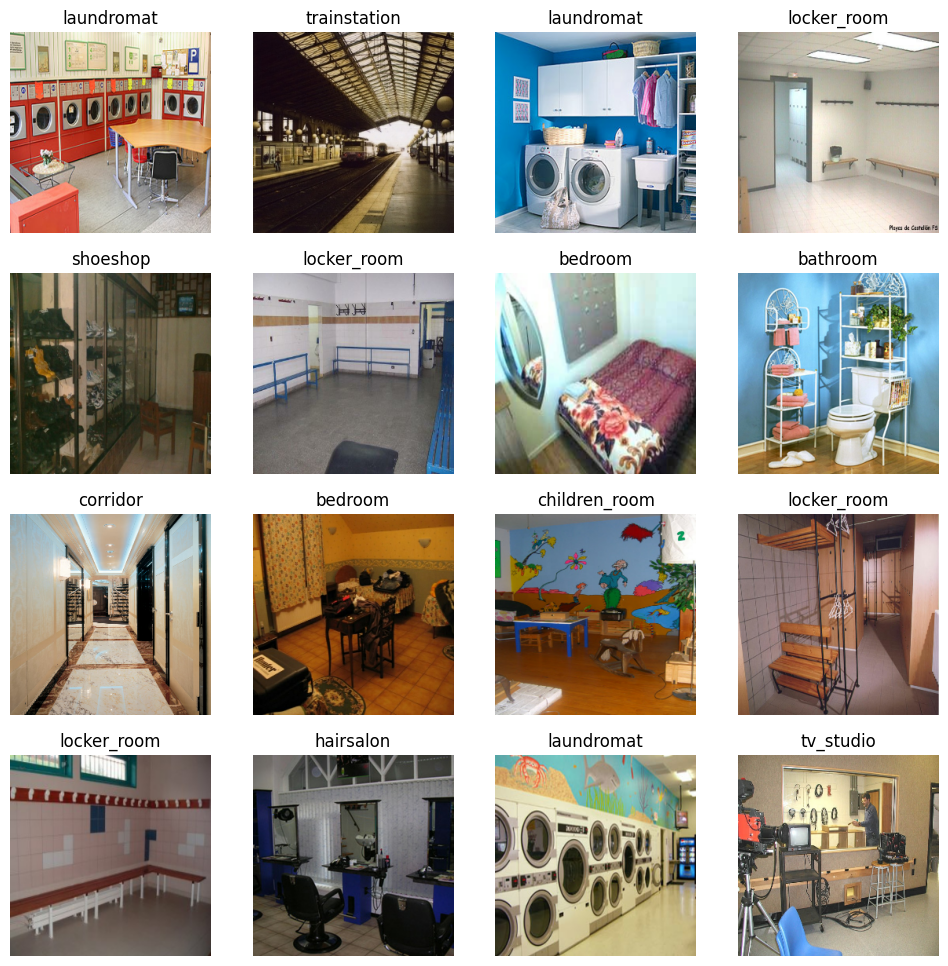

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for img, lab in val_data.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img[i].numpy().astype("uint16"))
    # Map the label index to name
    plt.title(room_dir[lab[i]])
    plt.axis("off")

## 2.Build a baseline CNN model on the training dataset and evaluate it on the test dataset.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE # Tune the value dynamically at runtime.

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)

In [14]:
num_labels = len(room_dir)
print(f'There are {num_labels} classes in the image dataset')
image_channel = 3
print(f' There are {image_channel} channels in the images')
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, image_channel)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_labels)
])

There are 17 classes in the image dataset
 There are 3 channels in the images


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

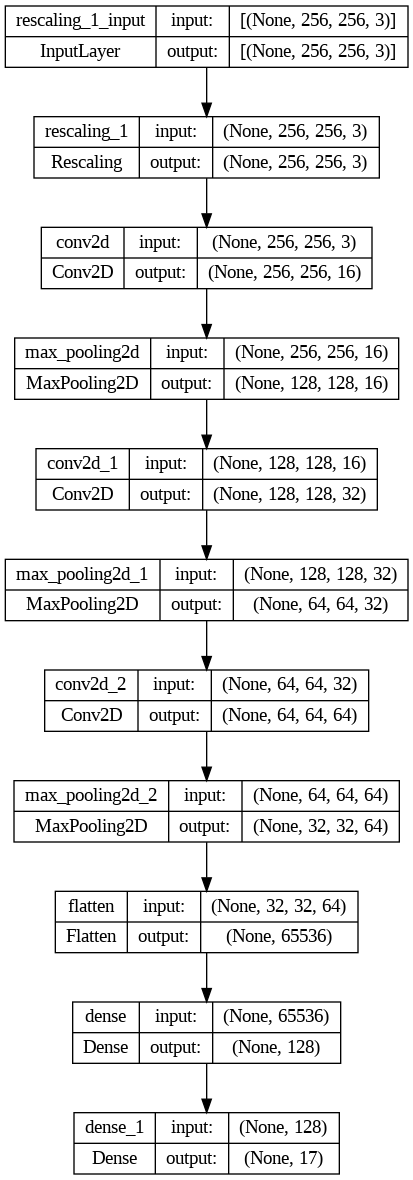

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)
epochs= 6
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback], verbose = 1
)

Epoch 1/6
86/86 [==============================] - 282s 3s/step - loss: 2.7767 - accuracy: 0.1855 - val_loss: 2.5591 - val_accuracy: 0.2141
Epoch 2/6
86/86 [==============================] - 227s 3s/step - loss: 2.3779 - accuracy: 0.2665 - val_loss: 2.2357 - val_accuracy: 0.2903
Epoch 3/6
86/86 [==============================] - 232s 3s/step - loss: 2.0766 - accuracy: 0.3464 - val_loss: 2.1644 - val_accuracy: 0.3270
Epoch 4/6
86/86 [==============================] - 228s 3s/step - loss: 1.6742 - accuracy: 0.4773 - val_loss: 2.0978 - val_accuracy: 0.3578
Epoch 5/6
86/86 [==============================] - 225s 3s/step - loss: 1.0738 - accuracy: 0.6690 - val_loss: 2.2944 - val_accuracy: 0.3592
Epoch 6/6
86/86 [==============================] - 236s 3s/step - loss: 0.5216 - accuracy: 0.8442 - val_loss: 3.2004 - val_accuracy: 0.3299
CPU times: user 32min 27s, sys: 4min 34s, total: 37min 1s
Wall time: 25min 34s


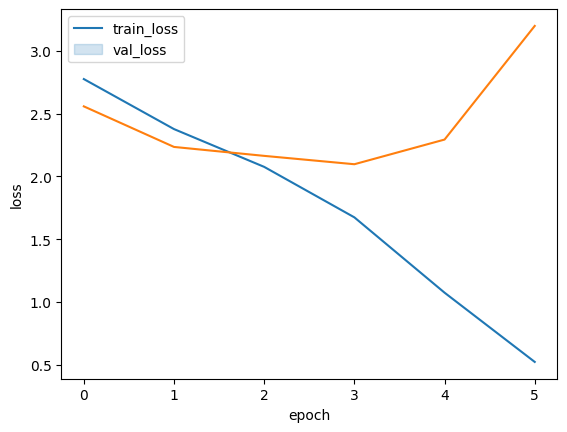

In [21]:
## Evaluate the Model
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
#Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
#Add legends
plt.legend(labels=['train_loss', 'val_loss'])

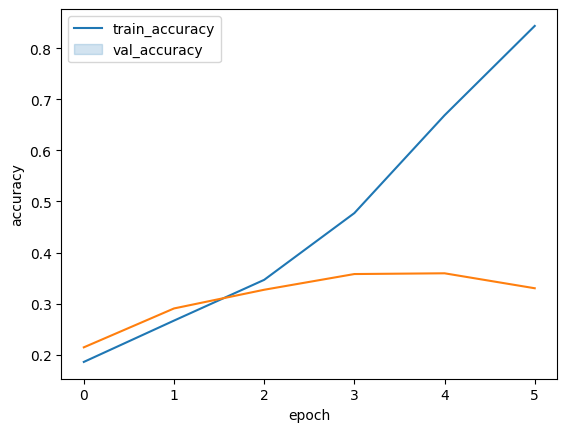

In [22]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
#Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

## 3.Build a second CNN model with data augmentation and dropout and evaluate it on the test dataset.

In [23]:
data_aug = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(image_height,
                                                              image_width,
                                                              image_channel)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1,width_factor = 0.1 ),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.1, 0.1))
  ]
)

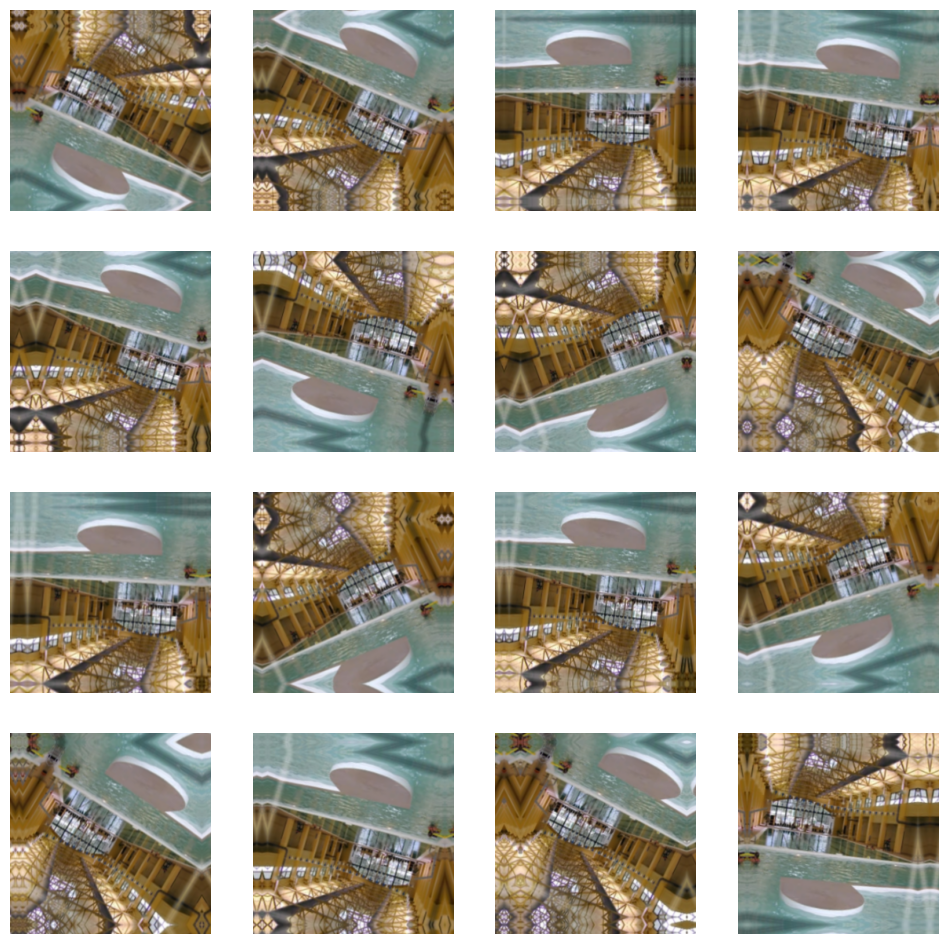

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for img, lab in train_data.take(1):
  for i in range(16):
    aug_images = data_aug(img)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(aug_images[0].numpy().astype("uint16"))
    plt.axis("off")

In [24]:
model = tf.keras.Sequential([
  # Data augmentation
  data_aug,
  # Data normalization
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_labels)
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)
epochs= 6
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback], verbose = 1
)

Epoch 1/6
86/86 [==============================] - 296s 3s/step - loss: 2.7368 - accuracy: 0.1855 - val_loss: 2.5772 - val_accuracy: 0.2243
Epoch 2/6
86/86 [==============================] - 299s 3s/step - loss: 2.5275 - accuracy: 0.2207 - val_loss: 2.4394 - val_accuracy: 0.2478
Epoch 3/6
86/86 [==============================] - 291s 3s/step - loss: 2.4131 - accuracy: 0.2434 - val_loss: 2.3657 - val_accuracy: 0.2639
Epoch 4/6
86/86 [==============================] - 294s 3s/step - loss: 2.3349 - accuracy: 0.2595 - val_loss: 2.3556 - val_accuracy: 0.2727
Epoch 5/6
86/86 [==============================] - 293s 3s/step - loss: 2.2928 - accuracy: 0.2687 - val_loss: 2.2306 - val_accuracy: 0.3035
Epoch 6/6
86/86 [==============================] - 288s 3s/step - loss: 2.2704 - accuracy: 0.2775 - val_loss: 2.2650 - val_accuracy: 0.3021
CPU times: user 41min 27s, sys: 5min 46s, total: 47min 14s
Wall time: 30min 46s


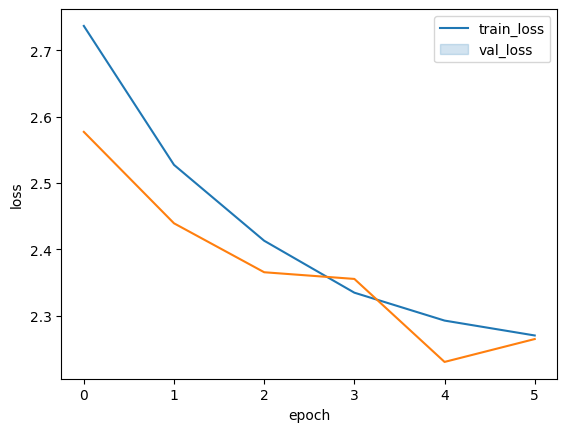

In [27]:
## Evaluate the Model
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
#Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
#Add legends
plt.legend(labels=['train_loss', 'val_loss'])

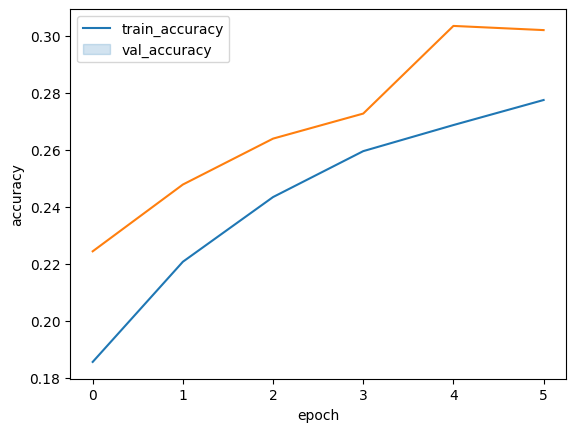

In [28]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
#Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

## 4.Build a third CNN model based on the pre-trained model(transfer learning) and evaluate it on the test dataset.

In [29]:
# Specify the image size for our dataset
IMG_SHAPE = (image_height, image_width, image_channel)
MobileNetV3Large_model = tf.keras.applications.MobileNetV3Large(input_shape = IMG_SHAPE,
                                               include_top=False, # Remove the fully-connected layer
                                               weights='imagenet') # Pre-training on ImageNet

12683000/12683000 [==============================] - 0s 0us/step


In [30]:
MobileNetV3Large_model.trainable = False

In [31]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [32]:
image_batch, label_batch = next(iter(train_data))
feature_batch = MobileNetV3Large_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 960)


In [33]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 960)


In [34]:
global_average_layer = tf.keras.layers.Flatten()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 61440)


In [35]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(f' The size of the predicted value for a given batch = {prediction_batch.shape}')

 The size of the predicted value for a given batch = (32, 17)


In [36]:
inputs = tf.keras.Input(shape = IMG_SHAPE)
x = data_aug(inputs)
x = preprocess_input(x)
x = MobileNetV3Large_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [37]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)
epochs= 6
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback], verbose = 1
)

Epoch 1/6
86/86 [==============================] - 217s 2s/step - loss: 6.8690 - accuracy: 0.4989 - val_loss: 3.8667 - val_accuracy: 0.7610
Epoch 2/6
86/86 [==============================] - 213s 2s/step - loss: 5.3686 - accuracy: 0.6778 - val_loss: 5.5420 - val_accuracy: 0.7199
Epoch 3/6
86/86 [==============================] - 213s 2s/step - loss: 4.8304 - accuracy: 0.7192 - val_loss: 5.0631 - val_accuracy: 0.7639
Epoch 4/6
86/86 [==============================] - 202s 2s/step - loss: 4.5905 - accuracy: 0.7496 - val_loss: 5.0218 - val_accuracy: 0.7874
Epoch 5/6
86/86 [==============================] - 206s 2s/step - loss: 4.7852 - accuracy: 0.7643 - val_loss: 6.5059 - val_accuracy: 0.7507
Epoch 6/6
86/86 [==============================] - 214s 2s/step - loss: 4.6834 - accuracy: 0.7698 - val_loss: 6.4737 - val_accuracy: 0.7698
CPU times: user 28min 3s, sys: 4min 41s, total: 32min 45s
Wall time: 24min 40s


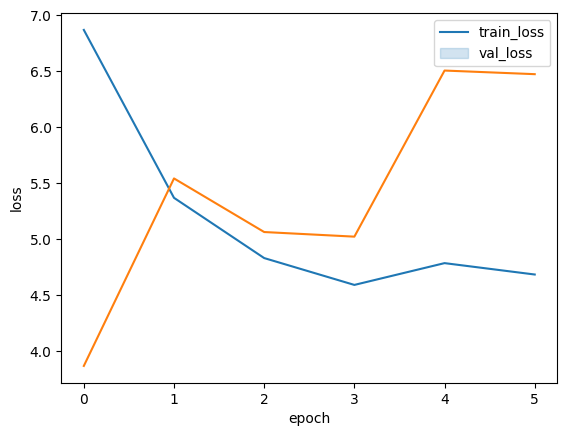

In [39]:
## Evaluate the Model
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
#Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
#Add legends
plt.legend(labels=['train_loss', 'val_loss'])

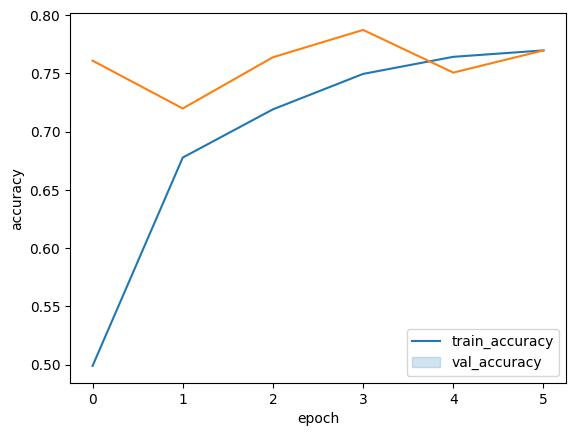

In [40]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
#Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

## 5.Which model do you recommend for the model in Q2, Q3, and Q4? Justify your answer.

In the first model, the validation accuracy starts at 0.2 and increases slightly to 0.3 over the same five epochs. However, it then starts decreasing and settles at 0.29. This behavior is concerning because the validation accuracy should ideally follow a similar increasing trend as the train accuracy. It should improve or at least remain stable over the training process, as the model learns from the training data.

The second model with data augmentation performed the best in terms of loss and accuracy. Both the training and validation data showed consistent signs of improvment compared to the other two models.

In the third model. The train accuracy increased from 0.5 to 0.76 over 5 epochs. This increase in train accuracy indicates that your model is learning from the training data and improving its ability to make correct predictions on the examples it has seen during training. It's generally a positive sign to observe an increasing trend in train accuracy during the early epochs of training, as it shows that the model is learning to fit the training data better.

The fluctuation in validation accuracy suggests that the model's performance on the validation dataset is not consistently improving.

## Part 2


You are a data scientist in an AI company. You are given a dataset of restaurant reviews. This is the sentiment140 dataset. It contains 1,600,000 tweets with six columns:

target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

ids: The id of the tweet ( for example, 2087)

date: the date of the tweet (for example, Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (for example, robotickilldozr)

text: the text of the tweet (for example, "Lyx is cool")

ex: "4","2052151722","Fri Jun 05 23:49:08 PDT 2009","NO_QUERY","ohiosweetie81","@AustinakaAA Wow you beat rockband 2? thats awesome Austin congrats on that  hope you had fun at the grove an what show?"

##1. Download the dataset that is about 81 MB from Kaggle into the local disk and unzip it.

## 2.Clean and preprocess the text data and split into training and test dataset.

In [5]:
data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', sep = ',',
                   header = None, names = ['target', 'ids', 'date', 'flag', 'user', 'text'])
data.head()

target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [ ]:
data.dtypes

In [7]:
data.target.value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [8]:
data.isnull().sum(axis = 0)

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [11]:
# Randomly shuffle the data
data_shuffled = data.sample(frac=1, random_state=42)

# Select 10,000 samples from each class (total 400,000)
data_reduced = pd.concat([data_shuffled[data_shuffled['target'] == 0].head(10000),
                          data_shuffled[data_shuffled['target'] == 4].head(10000)])
data = data_reduced
# Verify the class distribution in the reduced dataset
print(data_reduced['target'].value_counts())

0    10000
4    10000
Name: target, dtype: int64


In [10]:
#features and label
X = data['text'].values
y = data['target'].values

#split data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, stratify=y)

In [12]:
print(f'X_train size  ={X_train.shape}; X_test size  ={X_test.shape}')

X_train size  =(16000,); X_test size  =(4000,)


In [13]:
# Specify the vocab size
VOCAB_SIZE = 1000
# Perform textvectorization
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Fits the state of the preprocessing layer to the dataset.
encoder.adapt(X_train)

In [14]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'the', 'a', 'my', 'and', 'you', 'is', 'it',
       'for', 'in', 'im', 'of', 'on', 'me', 'so', 'have', 'that'],
      dtype='<U13')

## 3.Build a baseline RNN model using embedding layer and GRU on the training dataset and evaluate it on the test dataset.

In [15]:
model = tf.keras.Sequential([
    # Convert review text to indices
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    #
    tf.keras.layers.GRU(128, return_sequences=False),
    # Binary classifier
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

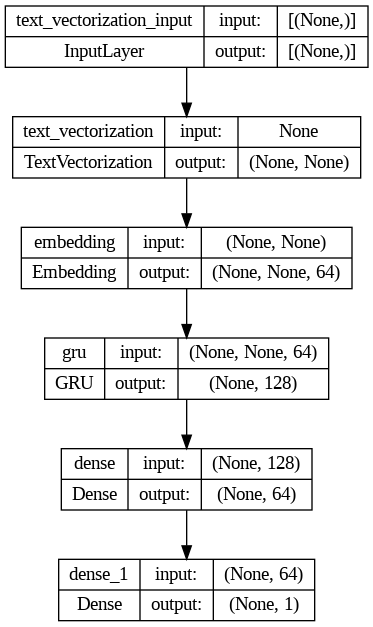

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [18]:
%%time
history = model.fit(x=X_train,y=y_train,batch_size= 32,epochs=5,
          validation_data=(X_test,y_test), verbose= 1
          )

Epoch 1/5
500/500 [==============================] - 19s 31ms/step - loss: -36.3155 - accuracy: 0.0021 - val_loss: -79.3392 - val_accuracy: 0.0000e+00
Epoch 2/5
500/500 [==============================] - 14s 29ms/step - loss: -126.2311 - accuracy: 0.0000e+00 - val_loss: -177.9793 - val_accuracy: 2.5000e-04
Epoch 3/5
500/500 [==============================] - 15s 31ms/step - loss: -240.5073 - accuracy: 0.0058 - val_loss: -310.3705 - val_accuracy: 0.0325
Epoch 4/5
500/500 [==============================] - 15s 30ms/step - loss: -387.9764 - accuracy: 0.0223 - val_loss: -467.1292 - val_accuracy: 0.0043
Epoch 5/5
500/500 [==============================] - 14s 29ms/step - loss: -561.5323 - accuracy: 0.0106 - val_loss: -652.9736 - val_accuracy: 0.0140
CPU times: user 1min 44s, sys: 4.61 s, total: 1min 49s
Wall time: 1min 18s


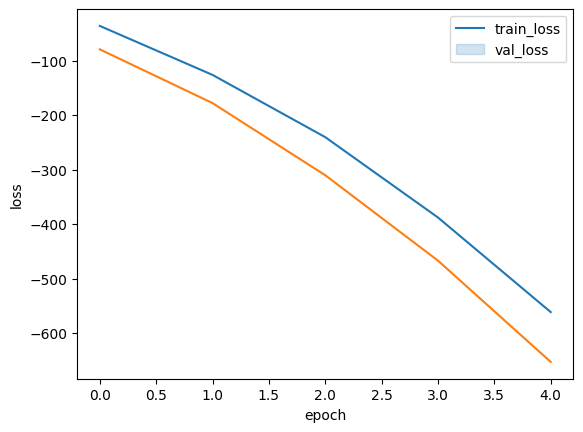

In [19]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
# Add legends
plt.legend(labels=['train_loss', 'val_loss'])

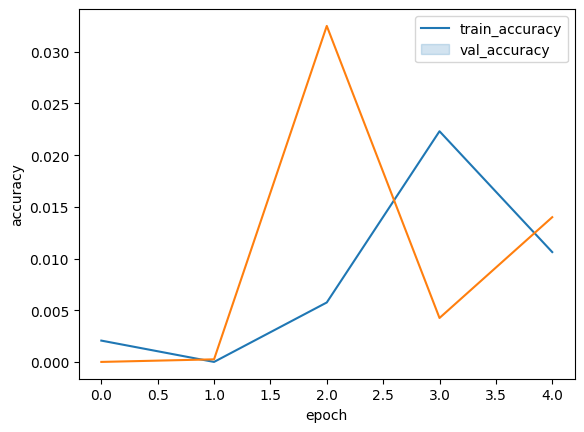

In [20]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

## 4.Build a second RNN model using embedding layer and LSTM and evaluate it on the test dataset.

In [21]:
model = tf.keras.Sequential([
    # Convert review text to indices
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    #tf.keras.layers.LSTM(128),
    # Binary classifier
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

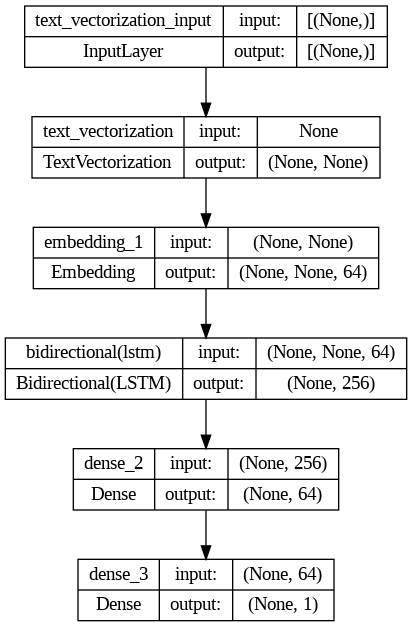

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
%%time
history = model.fit(x=X_train,y=y_train,batch_size= 32,epochs=5,
          validation_data=(X_test,y_test), verbose= 1
          )

Epoch 1/5
500/500 [==============================] - 45s 77ms/step - loss: -57.4341 - accuracy: 0.0014 - val_loss: -134.9580 - val_accuracy: 0.0000e+00
Epoch 2/5
500/500 [==============================] - 36s 73ms/step - loss: -227.4581 - accuracy: 1.8750e-04 - val_loss: -329.3804 - val_accuracy: 0.0015
Epoch 3/5
500/500 [==============================] - 36s 73ms/step - loss: -457.4477 - accuracy: 0.0020 - val_loss: -589.4456 - val_accuracy: 0.0040
Epoch 4/5
500/500 [==============================] - 36s 73ms/step - loss: -753.6619 - accuracy: 0.0048 - val_loss: -916.9293 - val_accuracy: 0.0063
Epoch 5/5
500/500 [==============================] - 36s 72ms/step - loss: -1111.2933 - accuracy: 0.0072 - val_loss: -1299.0245 - val_accuracy: 0.0077
CPU times: user 4min 31s, sys: 13.6 s, total: 4min 45s
Wall time: 3min 27s


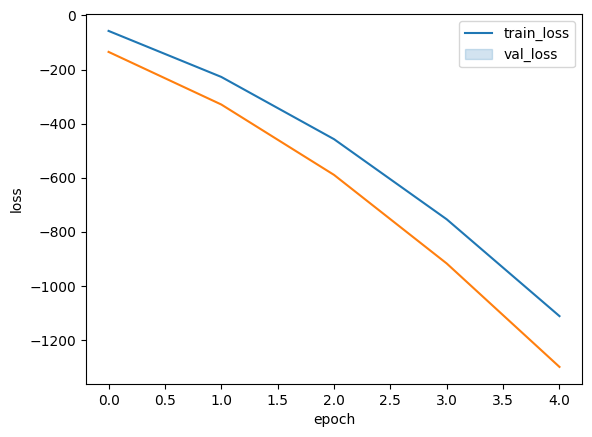

In [25]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
# Add legends
plt.legend(labels=['train_loss', 'val_loss'])

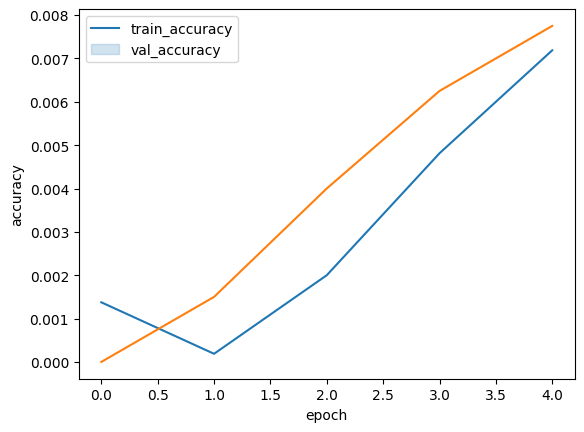

In [26]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

## 5.Build a third RNN model using embedding layer and GRU and LSTM and evaluate it on the test dataset.

In [27]:
model = tf.keras.Sequential([
    # Convert review text to indices
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    #
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    # Binary classifier
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [29]:
%%time
history = model.fit(x=X_train,y=y_train,batch_size= 32,epochs=5,
          validation_data=(X_test,y_test), verbose= 1
          )

Epoch 1/5
500/500 [==============================] - 71s 122ms/step - loss: -56.3273 - accuracy: 0.0477 - val_loss: -119.5851 - val_accuracy: 0.0000e+00
Epoch 2/5
500/500 [==============================] - 57s 113ms/step - loss: -192.8920 - accuracy: 6.2500e-05 - val_loss: -275.5551 - val_accuracy: 0.0010
Epoch 3/5
500/500 [==============================] - 59s 117ms/step - loss: -381.5613 - accuracy: 0.0049 - val_loss: -498.0628 - val_accuracy: 0.0178
Epoch 4/5
500/500 [==============================] - 56s 112ms/step - loss: -631.6554 - accuracy: 0.0694 - val_loss: -762.6599 - val_accuracy: 0.1050
Epoch 5/5
500/500 [==============================] - 57s 114ms/step - loss: -915.0266 - accuracy: 0.1270 - val_loss: -1068.3549 - val_accuracy: 0.1230
CPU times: user 7min 12s, sys: 23.3 s, total: 7min 36s
Wall time: 4min 58s


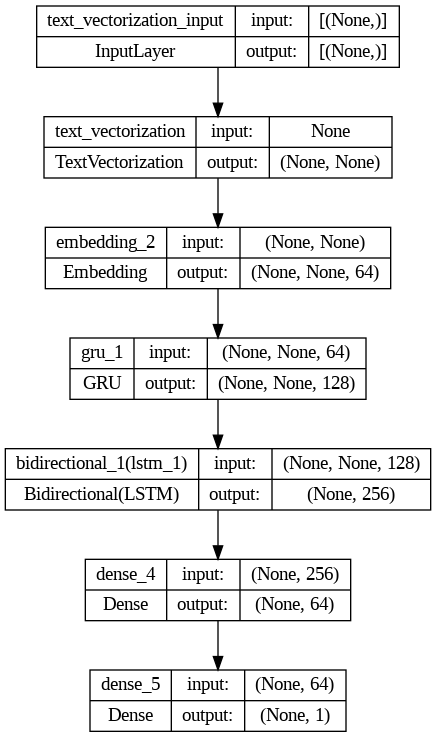

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True)

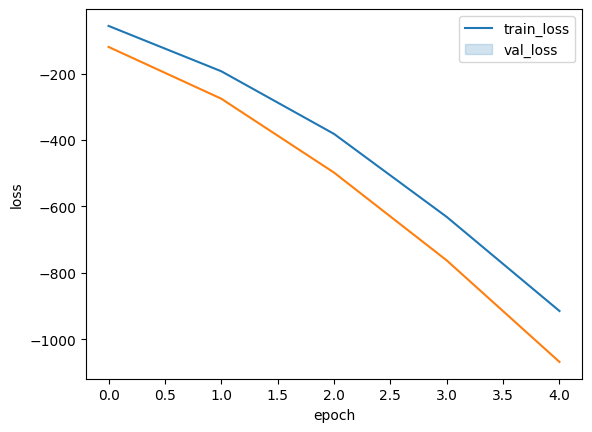

In [31]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
# Add legends
plt.legend(labels=['train_loss', 'val_loss'])

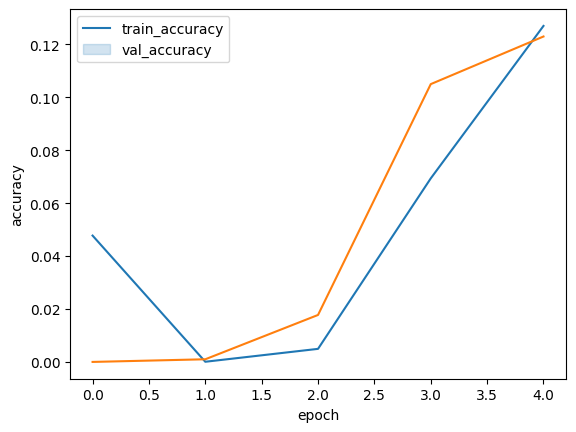

In [32]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

## 6.Which model do you recommend for the model in Q3, Q4, and Q5? Justify your answer.

Among these three models, Model 2 seems to be the most promising option. Model 2, has the most consistent and steady improvement in both training accuracy and validation accuracy. The training loss and validation loss trends are also consistent, suggesting that the model is learning and generalizing well.

In the first model, the decreasing training loss is expected and indicates that the model is learning and adjusting its parameters to minimize the loss function. The fluctuating behavior of the validation accuracy is concerning, as it should ideally increase or at least remain stable as the model learns from the training data. The fluctuations suggest that the model is not learning effectively and is having difficulty generalizing to unseen data.

In the second model, the consistency between training and validation loss trends is a positive sign, indicating that the model is learning and generalizing in a stable manner. The increase in training accuracy is a good sign as it shows that the model is learning and becoming better at correctly classifying examples from the training data.

In the third model, the validation loss being slightly below the training loss suggests that the model is generalizing well to some extent. The increase in training accuracy indicates that the model is learning to perform better on the training data and is becoming more accurate in its predictions. The consistent increase in validation accuracy is also encouraging.